# A/B тест

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Работа-с-таблицами" data-toc-modified-id="Работа-с-таблицами-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Работа с таблицами</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Распределение-пользователей-по-группам." data-toc-modified-id="Распределение-пользователей-по-группам.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Распределение пользователей по группам.</a></span></li><li><span><a href="#Распределение-событий-по-группам." data-toc-modified-id="Распределение-событий-по-группам.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Распределение событий по группам.</a></span></li><li><span><a href="#Распределение-событий-по-дням" data-toc-modified-id="Распределение-событий-по-дням-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Распределение событий по дням</a></span></li><li><span><a href="#Воронка-продаж" data-toc-modified-id="Воронка-продаж-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Воронка продаж</a></span></li></ul></li><li><span><a href="#Анализ-результатов-А/В-тестирования" data-toc-modified-id="Анализ-результатов-А/В-тестирования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов А/В тестирования</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

**Цель** — провести оценку результатов A/B-теста.

**Задачи**:

1. Оценить корректность проведения теста;
2. Проанализировать результаты теста;
3. Чтобы оценить корректность проведения теста, проверить: пересечение тестовой аудитории с конкурирующим тестом, совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
В наличии: датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Техническое задание**

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

## Изучение данных

In [1]:
!pip install kaleido

from plotly import graph_objects as go
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter 
from scipy import stats as st
from pymystem3 import Mystem
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import pandas as pd
import numpy as np
import math as mth
import kaleido
import os
import re

#Задаем константы
sns.set(rc={'figure.figsize':(15,10)})
sns.set_palette('pastel')
pio.renderers.default = "png"
svg_renderer = pio.renderers["png"]
svg_renderer.scale = 1.2

#Зададим функцию для безопасного извлечения датафрейма
def read_df(file_name):
    path1 = os.path.join('/datasets', file_name)
    path2 = os.path.join(file_name)
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        return df
    elif os.path.exists(path2):
        df = pd.read_csv(path2)
        return df
    else:
        print('File is not found')
        
#Зададим функцию для удобства ознакомления с датафреймами
def lazy_info(dt):
    x = dt.duplicated().sum()
    y = dt.shape[0]
    display(dt.head(5))
    dt.info()
    print(dt.isna().sum())
    print('Явных дубликатов', x, ', что составляет', "{:.2%}".format(x / y), 'от всех строк.')

In [2]:
marketing_events  = read_df('***')
new_users = read_df('***')
events = read_df('***')
participants = read_df('***')

In [3]:
lazy_info(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Явных дубликатов 0 , что составляет 0.00% от всех строк.


Меняем тип данных в столбцах с датами.

In [4]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')

In [5]:
lazy_info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
user_id       0
first_date    0
region        0
device        0
dtype: int64
Явных дубликатов 0 , что составляет 0.00% от всех строк.


Меняем тип данных в столбце с датами.

In [6]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

In [7]:
lazy_info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Явных дубликатов 0 , что составляет 0.00% от всех строк.


Меняем тип данных в столбце с датами и посмотрим на нашу будующую воронку.

In [8]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%dT%H:%M:%S')
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [9]:
lazy_info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
user_id    0
group      0
ab_test    0
dtype: int64
Явных дубликатов 0 , что составляет 0.00% от всех строк.


**Вывод**

Пропуски только в столбце <code>events['details']</code>. Количество записей в столбце соответсвует числу совершенных покупок. Пропуски обусловлены тем, что для других событий не подразумевается наличие дополнительной информации в виде цены купленного товара.

В остальных датасетах пропуски отсутствуют. Дубликаты в данных также не наблюдаются. Все столбцы с датами приведены к нужному типу.

## Работа с таблицами

Отобьем пользователей по интресующему нас тесту.

In [10]:
participants_1 = participants.query('ab_test == "recommender_system_test"')

Посмотрим даты

In [11]:
print('Минимальная первая дата:', events['event_dt'].min())
print('максимальная первая дата', events['event_dt'].max())

Минимальная первая дата: 2020-12-07 00:00:33
максимальная первая дата 2020-12-30 23:36:33


Тест закончился раньше врмени, причина нам не известна, но нам с этим жить. На всякий случай дополнительно отфильтруем таблицу событий.

In [12]:
events = events.query('event_dt >= "2020-12-07" and event_dt <= "2021-01-04"')

Уберем пользователей зарегистрировавшихся в неустраивающий нас период. 

In [13]:
new_users = new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')

Создадим своднцю таблицу для дальнейшей работы и выделим европейцев.

In [14]:
df = participants_1.merge(new_users, on='user_id', how='left')   
df = df.query('region == "EU"')

In [15]:
#Смотрим количество участников
print('Итого участников теста: ',df['user_id'].nunique())
#Смотрим процентаж европейцев
df['user_id'].nunique() / new_users.query('region == "EU"')['user_id'].nunique()

Итого участников теста:  6351


0.15

Получается, что колчиество пользователей и процентаж совпадают с запланированными (почти).
***
Просмотрим промоакции.

In [16]:
#Отберем те которые происходили в интересующий нас промежуток
marketing_events.query('start_dt >= "2020-12-07" and finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


К сожалению нам неизвестна направленость акции, но она определенно исказила данные, придётся иметь это в виду. 
***
Проверим пересечения тестов, для этого смерджим еще одну таблицу.

In [17]:
df = df.merge(events, on='user_id', how='left').reset_index(drop=True)
#Смотрим пересечения
print(participants.query('ab_test == "recommender_system_test"')['user_id']
      .isin(participants.query('ab_test == "interface_eu_test" and group =="B"')['user_id']).sum()
     )
x = len(df)
#Фильруем
df = df[~df['user_id'].isin(participants[(participants['ab_test']=='interface_eu_test')&(participants['group']=='B')]['user_id'])]
y = len(df)
#Проверяем
print(df.query('group == "A"')['user_id'].isin(df.query('group == "B"')['user_id']).sum())
print('Пришлось отбросить', "{:.2%}".format(1 - y / x))

783
0
Пришлось отбросить 12.20%


Проследим, чтобы лайфтайм событий был не больше 14 дней.

In [18]:
from datetime import datetime
#Создаём столбец под это
df['lt'] = df['event_dt'] - df['first_date']
#
df['lt'] = [x.days for x in df['lt']]
x = len(df)
#Отсекаем
#df = df.query('lt <= 14')
y = len(df)
print('Пришлось отбросить', "{:.2%}".format(1 - y / x),'а именно:', x-y)

Пришлось отбросить 0.00% а именно: 0


Таблица готова к дальнейшей работе, ТЗ соблюдено.

## Исследовательский анализ данных

### Распределение пользователей по группам.

In [19]:
temp = df.groupby('group',as_index=False).agg({'user_id':'nunique'})
if temp['user_id'][0] / temp['user_id'][1] > .5:
    display(temp)
    print('Распределение не равно')
else:
    print('Распределение в порядке')

,group,user_id
0,A,3195
1,B,2373


Распределение не равно


### Распределение событий по группам.

In [20]:
temp = df.groupby('group',as_index=False).agg({'event_name':'count'})
temp['events_on_user'] = (temp['event_name'] / df.groupby('group',as_index=False).agg({'user_id':'nunique'})['user_id']).round(2)
temp

,group,event_name,events_on_user
0,A,16154,5.06
1,B,4410,1.86


Различия количества событий на пользователя, так же значительно.

### Распределение событий по дням

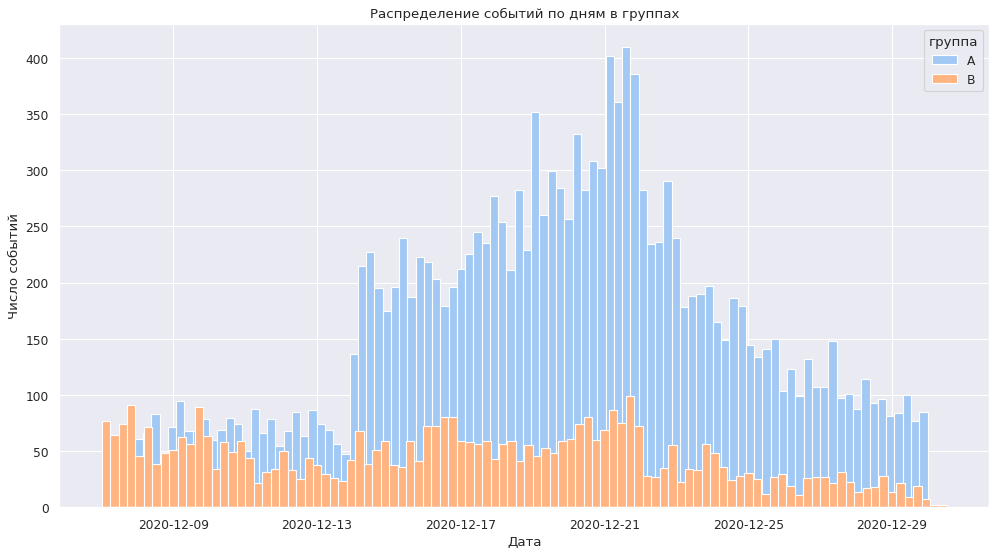

In [21]:
fig, ax = plt.subplots(figsize=(15,8), dpi = 80)

df.query('group=="A"')['event_dt'].hist(bins=100,label='A')
df.query('group=="B"')['event_dt'].hist(bins=100,label='B')

ax.legend(title = 'группа')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.title('Распределение событий по дням в группах');

На лицо скачок у группы **А** 14 декабря, возможно существовала еще одна промоакция о которой забыли нам сообщить. Группе **В** характерна некоторая постоянность. 22 декабря обе группы сталкиваются со спадом.

### Воронка продаж

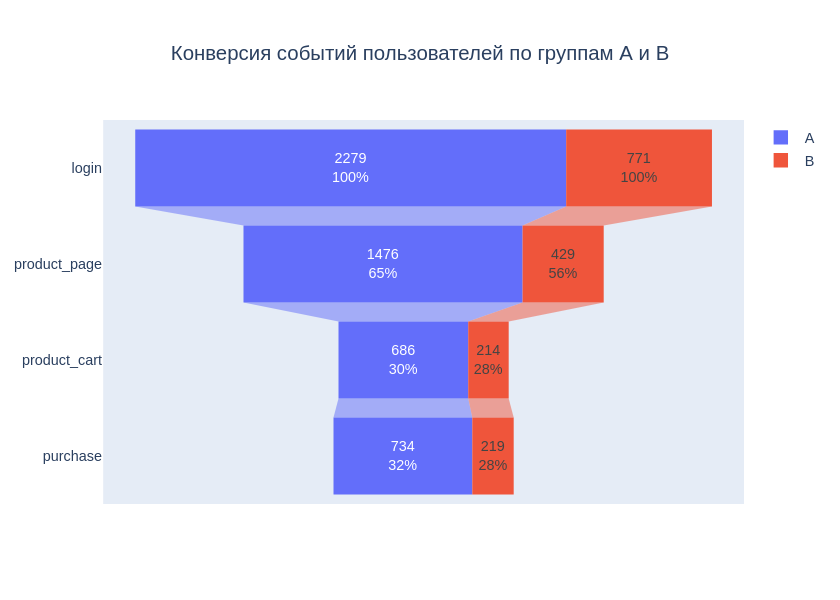

In [22]:
#Наша воронка выглядит так: login → product_page → product_cart → purchase. 
#Построим для группы А
grpA = (df
        .query('group == "A"')
        .groupby('event_name',as_index=False)
        .agg({'user_id':'nunique'})
        .sort_values('user_id', ascending = False)
        .reindex([0,2,1,3])
       )

#Построим для группы В
grpB = (df.query('group == "B"')
        .groupby('event_name',as_index=False)
        .agg({'user_id':'nunique'})
        .sort_values('user_id', ascending = False)
        .reindex([0,2,1,3])
       )

fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'A',
    y = grpA['event_name'],
    x = grpA['user_id'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'B',
    y = grpB['event_name'],
    x = grpB['user_id'],
    textinfo = "value+percent initial"))
fig.update_layout(
    title = {
        'text' : 'Конверсия событий пользователей по группам А и В',
        'x':0.5
    }
)
fig.show()

Продполагался рост конверсии группы **В**, но она получилась даже меньше чем у группы **А 28%** к **32%**. Это уже провал, но тестирование доведем до конца. Правда стоит учитывать, что группы уже не равны по колчиеству участников и  по количеству событий.  

## Анализ результатов А/В тестирования

Создадим вспомогательную таблицы.

In [23]:
temp = df.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').reset_index()
temp_1 = df.groupby('group',as_index=False).agg({'user_id':'nunique'})

Для удобства напишем функцию.

In [24]:
#определим функцию для проведения теста на равенство долей
def z_test(group1, group2, event, alpha=0.05):
    successes1 = temp[temp['event_name']==event][group1].iloc[0]
    successes2 = temp[temp['event_name']==event][group2].iloc[0]
    trials1 = temp_1[temp_1['group']== group1]['user_id'].iloc[0]
    trials2 = temp_1[temp_1['group']== group2]['user_id'].iloc[0]
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2  
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    #применим поправку Бонферрони
    alpha = alpha / 4 
    #значение p для двухсторонней гипотезы
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница для события", event, 'для групп', group1, 'и', group2)
    else:
        print("Не получилось отвергнуть нулевую гипотезу для события", event, 'для групп', group1, 'и', group2)  

Проверим, есть ли различия в долях пользователей в событиях контрольных группах.

- Нулевая гипотеза: Между долями пользователей групп нет статистических различий.

- Альтернативная гипотеза: Между долями пользователей групп есть статистические различия.

In [25]:
for event in temp.event_name.unique():
    z_test('A', 'B', event, 0.05)

p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события login для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события product_cart для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события product_page для групп A и B
p-value:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница для события purchase для групп A и B


Статистическая разница присутствует у всех событий, но не в ту сторону в которую хотелось бы нам.

## Вывод

Во время обработки таблиц с результатами А/В теста и приведениюх их к ТЗ, было обнаружено:
- Обрыв данных по действиям юзеров 30 декабря, а не 4 января как планировалось изначально
- Данные включали в себя сведенья о пользователях зарегистрированных после 21 декабря, хотя не должны были
- В тесте принимали участие пользователи из нецелевых регионов 
- Тест проводился параллельно с конкурирующим тестом
- Во время теста проводились промоакции, возможно повлиявшие на результат
- Группы для теста распределены не коректно
- Целевой показатель роста конверсии 10% не достигнут

Рекомендации: 
- Разносить разные тесты по времени, чтобы не допускать пересечений 
- Провоить А/А тест перед А/В тетсом
- На время теста не проводить промоакции 